### 의사결정나무(DT)
- IF-ELSE 방식의 질문에 대한 답변으로 문제를 해결하는 알고리즘
- 피쳐(특성) 중에서 선택한 기준으로 데이터 분할
    - 엔트로피 (불순정도) => 낮아지는 방향
    - 정보이득 : 1-엔트로피 => 높아지는 방향
    - 지니계수 : 불평등수치값 => 낮아지는 방향
- 단점 : 과대적합이 될 가능성 높음. 성능이 좋지 않음
- 장점 : 전처리 영향을 받지 않음. 직관성이 높음. 피쳐들 중 주요 피쳐 확인 가능
- 주의
    - 여기서의 주요 피쳐는 데이터 분할을 위한 중요 피쳐
    - 100% 데이터의 주요 피쳐가 아닐 수도 있음 => 다른 검사(상관계수, 시각화 등)와 함께 평가

(1) 모듈 로딩 및 데이터 준비 <hr>

In [1]:
import pandas as pd

In [2]:
irisDF = pd.read_csv('../DATA/iris.csv')
irisDF.head(3)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa


(2) 학습용 데이터 셋 준비 <hr>

In [3]:
# (2-1) 피쳐와 타겟 분리
featureDF = irisDF[irisDF.columns[:-1]]
targetSR = irisDF['species']
featureDF.shape, targetSR.shape

((150, 4), (150,))

In [4]:
# (2-2) 훈련용, 테스트용 데이터셋 분리
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(featureDF, targetSR, test_size=0.2, stratify=targetSR)

(3) 기계학습 진행 <hr>
- 타겟 데이터 확인 결과 : 3개의 분류
- 학습 유형 : 지도학습 + 분류
- 분류 알고리즘 => KNN, LogisticRegression, SVM-SVC, DecisionTree

In [5]:
from sklearn.tree import DecisionTreeClassifier

In [6]:
# 인스턴스 생성
model = DecisionTreeClassifier()
model.fit(x_train, y_train)

DecisionTreeClassifier()

In [7]:
# 생성된 모델 구조 시각화
from sklearn.tree import export_graphviz

In [34]:
# DT 모델의 시각화 정보를 dot 언어로 작성해서 파일로 저장
export_graphviz(model, 'iris_dt_model.dot'
                # , feature_names=featureDF.columns
                , feature_names=model.feature_names_in_
                # , class_names=targetSR.unique()
                , class_names=model.classes_
                , filled=True   # 클래스별 색상 채워짐
                # , max_depth=3   # 시각화할 최대 depth 지정
                )

In [35]:
# dot 언어로 작성된 내용을 시각화 해주는 모듈
from graphviz import Source

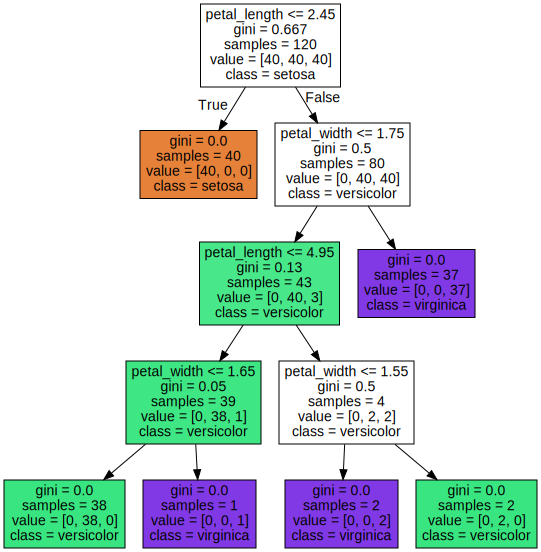

In [36]:
Source.from_file('iris_dt_model.dot')

(4) 모델 평가 <hr>

In [40]:
# 평가 결과, 과대적합
print(f'[TRAIN] : model.score(x_train, y_train)', f'[TEST] : model.score(x_test, y_test)', sep='\n')

[TRAIN] : model.score(x_train, y_train)
[TEST] : model.score(x_test, y_test)


(5) 문제 해결 및 성능 향상, 즉 튜닝 <hr>
- 원인 예상
    - 데이터 셋 부족  => cv
    - DT의 여러 가지 하이퍼 파라미터 기본값으로만 사용  => 다양한 값으로 조절
- 해결 방법
    - 2개의 원인을 한꺼번에 해결하기 위해, GridSearchCV

In [41]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [43]:
# 모델 조합 조건
# cv => 기본 5, ...
# DT의 하이퍼 파라미터 => max_depth, ...
dt_model = DecisionTreeClassifier()
n_cv = 5
params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 4, 6]
}

# 하이퍼 파라미터 조합된 모델 생성 후 교차검증 데이터셋으로 학습진행 해주는 인스턴스
# 훈련 점수를 알고 싶다면 return_train_score=True 설정을 해주면 된다.
gs = GridSearchCV(dt_model, param_grid=params, cv=n_cv)

In [44]:
# 조합된 모델들의 학습 진행
result = gs.fit(x_train, y_train)
result

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [5, 10, 15],
                         'min_samples_split': [2, 4, 6]})

In [48]:
# 학습 후 저장된 모델 파라미터 확인
cv_resultsDF = pd.DataFrame(gs.cv_results_)  # 교차학습 결과  (gs.cv_results_ : dict)
cv_resultsDF    # 조합된 모델의 개수 : 27개 (3x3x3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002214,0.000808,0.001475,0.000501,gini,5,2,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.958333,0.916667,0.916667,0.875,0.958333,0.925000,0.031180,13
1,0.001268,0.000435,0.001035,0.000019,gini,5,4,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.958333,0.916667,0.916667,0.875,0.958333,0.925000,0.031180,13
2,0.001756,0.000551,0.001110,0.000028,gini,5,6,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.958333,0.916667,0.916667,0.875,1.000000,0.933333,0.042492,10
3,0.001966,0.000454,0.001129,0.000047,gini,10,2,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.958333,0.916667,0.916667,0.875,0.958333,0.925000,0.031180,13
4,0.001590,0.000556,0.001135,0.000031,gini,10,4,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.958333,0.916667,0.916667,0.875,0.958333,0.925000,0.031180,13
5,0.001565,0.000474,0.001511,0.000574,gini,10,6,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.958333,0.916667,0.916667,0.875,1.000000,0.933333,0.042492,10
6,0.001293,0.000381,0.000863,0.000434,gini,15,2,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.958333,0.916667,0.916667,0.875,0.958333,0.925000,0.031180,13
7,0.001112,0.000042,0.001092,0.000046,gini,15,4,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.958333,0.916667,0.916667,0.875,0.958333,0.925000,0.031180,13
8,0.001386,0.000457,0.000892,0.000450,gini,15,6,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.958333,0.916667,0.916667,0.875,1.000000,0.933333,0.042492,10
9,0.001450,0.000360,0.000749,0.000587,entropy,5,2,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.916667,0.916667,0.916667,1.000,0.958333,0.941667,0.033333,7


In [49]:
# 조합된 모델 중 최고의 성능을 내는 하이퍼 파라미터 값
gs.best_params_

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 6}

In [50]:
# 조합된 모델 중 최고의 (테스트) 점수
gs.best_score_

0.95

In [51]:
# 조합된 모델 중 최고의 성능을 내는 모델 인스턴스
my_best_model = gs.best_estimator_

(6) 학습 및 튜닝 후 모델 저장 <hr>
- 다른 파일에서 활용이 가능한 파일 형태로 저장
- 웹/앱 원하는 곳에서 활용 가능
- scikit-learn에서는 pickle 포맷으로 저장
- joblib 모듈에 해당 기능 포함되어 있음

In [54]:
import joblib
import os

In [57]:
# 모델 저장
model_dir = '../model/'
model_filename = model_dir + 'iris_best_model.pkl'

# 저장 폴더 존재여부 확인 후 저장
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

joblib.dump(my_best_model, model_filename)

['../model/iris_best_model.pkl']